# Hazard: Tropical cyclone rain from R-CLIPER or TCR model

The `TCRain` class models precipitation generated by tropical cyclones. Given a `TCTracks` instance, it computes the precipitation rates (in mm/h) for each historical and/or synthetic track at every centroid and track position. The precipitation rates are then translated into total amounts of rainfall (in mm) by multiplying with each track's time step sizes and summation over the whole storm life time. `TCRain` inherits from `Hazard` and has an associated hazard type `"TR"`.

## Model description: R-CLIPER

The statistical model **R-CLIPER** ([Tuleya et al. 2007](https://doi.org/10.1175/WAF972.1)) assumes a radially symmetric distribution of the precipitation rate around the storm center. The shape of the radial profile increases linearly from the storm center to the boundary of the inner core, and decreases exponentially outside of it:

$$T_0 + (T_m - T_0) (r / r_m) \quad\text{for}\quad r \leq r_m,$$
$$T_m \exp(-(r - r_m) / r_e) \quad\text{for}\quad r > r_m,$$

where

- $r_m$ : the radial extent of the inner-core precipitation rate,
- $r_e$ : a measure for the total radial extent of the tropical rain field,
- $T_0$ : the precipitation rate at the center of the storm (at $r=0$),
- $T_m$ : the maximum precipitation rate (at $r=r_m$).

These four quantities are estimated via linear statistical relationships from the maximum wind speed variable of the storm track, which is the only along-track variable that is considered in this model except from the storm's position.

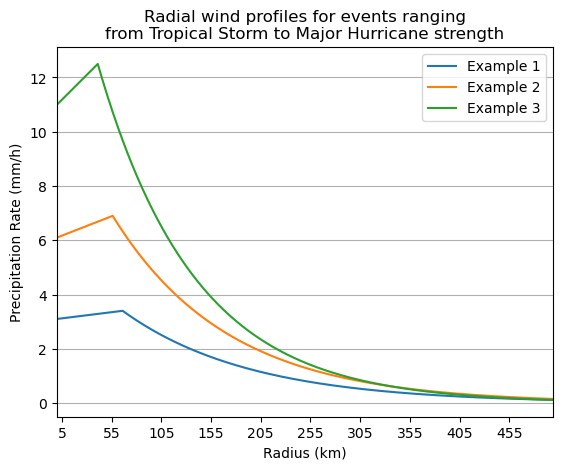

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

import numpy as np
import matplotlib.pyplot as plt

l_T0 = np.array([3.1, 6.1, 11.0])
l_Tm = np.array([3.4, 6.9, 12.5])
l_rm = np.array([66.0, 56.0, 41.0])
l_re = np.array([128.0, 116.0, 98.0])

radius = np.arange(0, 500, dtype=float)

for i, (T_0, T_m, r_m, r_e) in enumerate(zip(l_T0, l_Tm, l_rm, l_re)):
    rainrate = np.zeros_like(radius)
    msk = radius <= r_m
    rainrate[msk] = T_0 + (T_m - T_0) * (radius[msk] / r_m)
    rainrate[~msk] = T_m * np.exp(-(radius[~msk] - r_m) / r_e)
    plt.plot(radius, rainrate, label=f"Example {i + 1}")

plt.title(
    "Radial wind profiles for events ranging\n"
    "from Tropical Storm to Major Hurricane strength"
)
plt.xticks(np.arange(5, 500, 50))
plt.xlim(radius.min(), radius.max())
plt.yticks(np.arange(0, 13, 2))
plt.grid(axis="y")
plt.xlabel('Radius (km)')
plt.ylabel('Precipitation Rate (mm/h)')
plt.legend()
plt.show()

## Model description: TCR

The physics-based model **TCR** ([Zhu et al. 2013](https://doi.org/10.1002/2013GL058284), [Emanuel 2017](https://doi.org/10.1073/pnas.1716222114)) assumes that the precipitation rate at each centroid is proportional to the vertical vapor flux $w_q = q_s \cdot w$, where $q_s$ is the saturation specific humidity and $w$ is the vertical velocity. The implementation in CLIMADA follows the description in [Lu et al. 2018](https://doi.org/10.1175/JAS-D-17-0264.1) and includes the improvements proposed in [Feldmann et al. 2019](https://doi.org/10.1175/JAMC-D-19-0011.1). The saturation specific humidity $q_s$ is assumed to be constant over the rain field and can be estimated from the 600 hPa temperature at the storm center. The focus of this model is on an accurate description of the vertical velocity $w$ as the sum of the following five components:

- $w_f$ : friction-induced (interaction between horizontal winds and the surface roughness),
- $w_h$ : topographically induced (interaction between horizontal winds and the surface slope),
- $w_t$ : vortex stretching-induced (changes in the storm's vorticity over time),
- $w_s$ : shear-induced (baroclinic interaction of the upper and lower troposphere),
- $w_r$ : radiative cooling-induced (constant subsidence everywhere on Earth).

The calculation of these components requires horizontal TC wind fields as provided by CLIMADA's `TropCyclone` class. While any TC wind model can be combined with TCR, this implementation chooses `"ER11"` by default since this is the one that is used in most studies that apply TCR. Note that the default wind model in `TropCyclone` is `"H08"`.

In addition to common along-track variables, the TCR model requires four additional variables:

- gridded topography (surface elevation),
- gridded drag coefficients (e.g. derived from surface roughness),
- along-track 600 hPa temperature at the storm center,
- along-track 850 hPa wind speeds averaged over an annulus of 200-500 km around the storm center.

While default data sets for topography and drag coefficients are provided with CLIMADA and do not need further considerations for most applications, the additional temperature and wind speed variables need to be provided by the user. For existing TC track data sets, both variables can be extracted from reanalysis and climate model data. For example, when using historical IBTrACS records, it is recommended to extract the variables from the ERA5 reanalysis which provides global hourly data on pressure levels. On the other hand, providers of synthetic track sets based on climate models (e.g. [CHAZ](https://github.com/cl3225/CHAZ)) can often provide both variables (as extracted from the climate model outputs) along with the track data.

## Examples

We compute the rain fields of Sidr 2007 and Roanu 2016 over Bangladesh as follows:

2023-07-06 12:32:45,690 - climada.hazard.tc_tracks - INFO - Progress: 50%
2023-07-06 12:32:45,701 - climada.hazard.tc_tracks - INFO - Progress: 100%
2023-07-06 12:32:45,721 - climada.hazard.tc_tracks - INFO - Interpolating 2 tracks to 0.5h time steps.


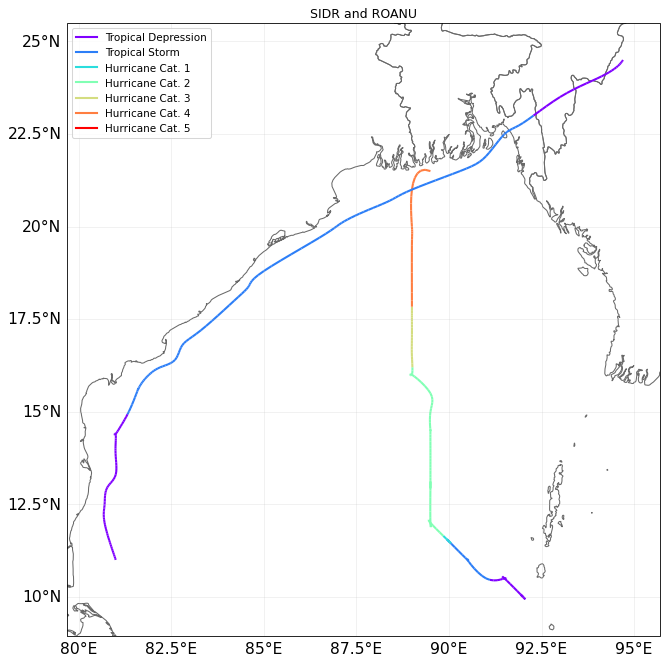

In [2]:
mpl.rcParams['figure.dpi'] = 75

from climada.hazard import TCTracks

tracks = TCTracks.from_ibtracs_netcdf(
    # SIDR 2007 and ROANU 2016
    storm_id=['2007314N10093', '2016138N10081'],
)
tracks.equal_timestep(0.5)
ax = tracks.plot()
ax.get_legend()._loc = 2
ax.set_title('SIDR and ROANU');

In [3]:
from climada.hazard import Centroids

# define centroids and restrict to points on land
min_lat, max_lat, min_lon, max_lon = 21.0, 24.5, 88.5, 92.5
cent_bang = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.015)
cent_bang.set_dist_coast(signed=True, precomputed=True)
cent_bang.dist_coast *= -1.0
cent_bang.dist_coast[cent_bang.dist_coast < 0] = 9000e3
cent_bang.check()

2023-07-06 12:32:49,943 - climada.util.coordinates - INFO - Sampling from SYSTEM_DIR/GMT_intermediate_coast_distance_01d.tif


### Rain field output with R-CLIPER

2023-07-06 12:32:50,068 - climada_petals.hazard.tc_rainfield - INFO - Mapping 2 tracks to 45839 coastal centroids.
2023-07-06 12:32:50,792 - climada_petals.hazard.tc_rainfield - INFO - Progress: 50%


2023-07-06 12:32:51,767 - climada_petals.hazard.tc_rainfield - INFO - Progress: 100%


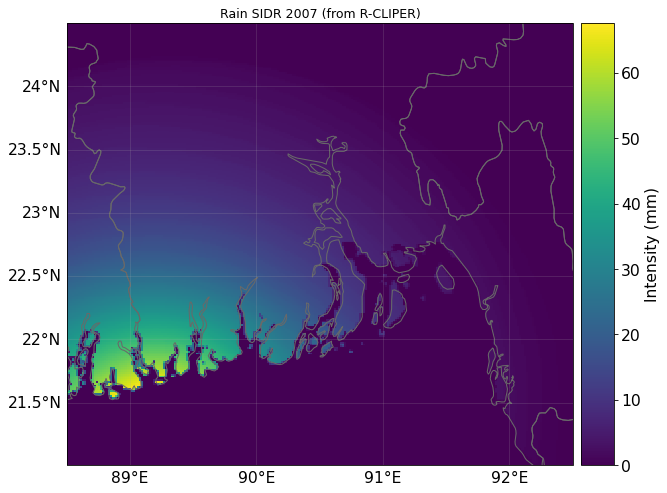

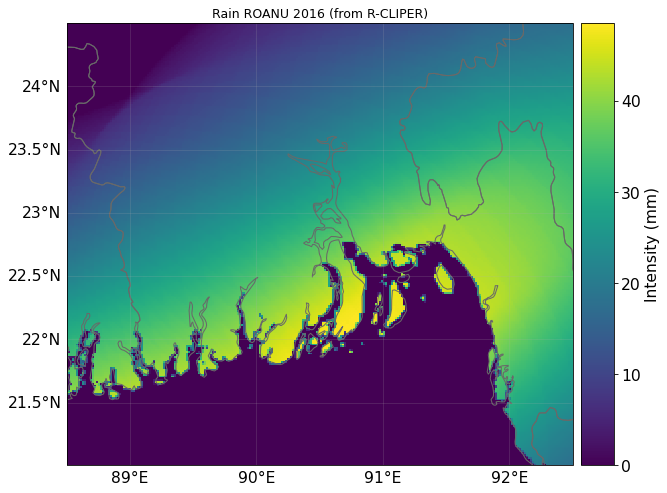

In [4]:
from climada_petals.hazard import TCRain

tr_bang = TCRain.from_tracks(tracks, centroids=cent_bang, model="R-CLIPER")
ax = tr_bang.plot_intensity(1)
ax.set_title('Rain SIDR 2007 (from R-CLIPER)')
ax = tr_bang.plot_intensity(2)
ax.set_title('Rain ROANU 2016 (from R-CLIPER)');

### Rain field output with TCR

2023-07-06 12:32:58,711 - climada_petals.hazard.tc_rainfield - INFO - Mapping 2 tracks to 45839 coastal centroids.
2023-07-06 12:33:00,513 - climada.util.coordinates - INFO - Sampling from SYSTEM_DIR/era-5_C_Drag500-corrected.tif
2023-07-06 12:33:01,596 - climada.util.coordinates - INFO - Sampling from SYSTEM_DIR/srtm15_v2.3_300as.tif
2023-07-06 12:33:02,252 - climada_petals.hazard.tc_rainfield - INFO - Progress: 50%


2023-07-06 12:33:04,695 - climada.util.coordinates - INFO - Sampling from SYSTEM_DIR/era-5_C_Drag500-corrected.tif
2023-07-06 12:33:06,118 - climada.util.coordinates - INFO - Sampling from SYSTEM_DIR/srtm15_v2.3_300as.tif
2023-07-06 12:33:06,914 - climada_petals.hazard.tc_rainfield - INFO - Progress: 100%


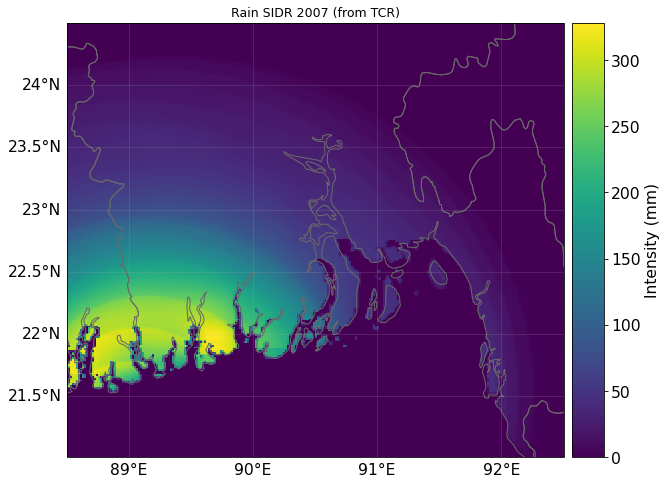

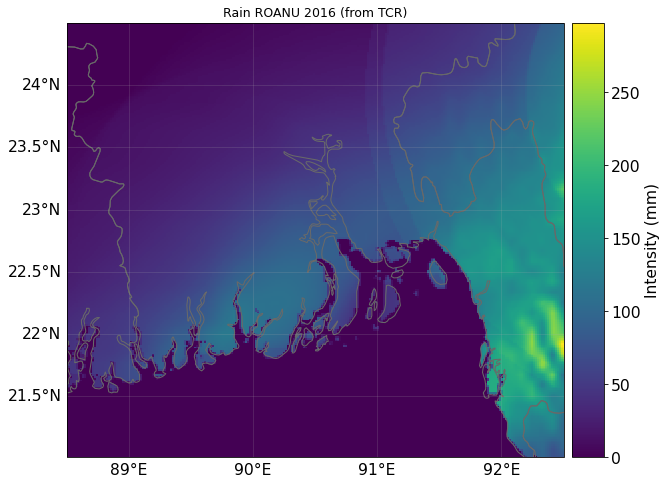

In [5]:
tr_bang = TCRain.from_tracks(tracks, centroids=cent_bang, model="TCR")
ax = tr_bang.plot_intensity(1)
ax.set_title('Rain SIDR 2007 (from TCR)')
ax = tr_bang.plot_intensity(2)
ax.set_title('Rain ROANU 2016 (from TCR)');

Since TCR has additional requirements on the available along-track variables, the above examples omit or simplify two effects in the model:

- A constant universal estimate is assumed for the specific humidity $q_s$, which has a large influence on the rain rate as it is directly proportional.
- The shear-induced component of the vertical velocity `w_s` is omitted.

For the two tracks considered in this tutorial, CLIMADA provides a track data set that includes the required along-track variables as extracted from the ERA5 reanalysis:

2023-07-06 12:33:13,642 - climada.hazard.tc_tracks - INFO - Interpolating 2 tracks to 0.5h time steps.
2023-07-06 12:33:13,696 - climada_petals.hazard.tc_rainfield - INFO - Mapping 2 tracks to 45839 coastal centroids.


2023-07-06 12:33:15,569 - climada.util.coordinates - INFO - Sampling from SYSTEM_DIR/era-5_C_Drag500-corrected.tif
2023-07-06 12:33:16,762 - climada.util.coordinates - INFO - Sampling from SYSTEM_DIR/srtm15_v2.3_300as.tif
2023-07-06 12:33:17,801 - climada_petals.hazard.tc_rainfield - INFO - Progress: 50%


2023-07-06 12:33:20,243 - climada.util.coordinates - INFO - Sampling from SYSTEM_DIR/era-5_C_Drag500-corrected.tif
2023-07-06 12:33:21,432 - climada.util.coordinates - INFO - Sampling from SYSTEM_DIR/srtm15_v2.3_300as.tif
2023-07-06 12:33:22,644 - climada_petals.hazard.tc_rainfield - INFO - Progress: 100%


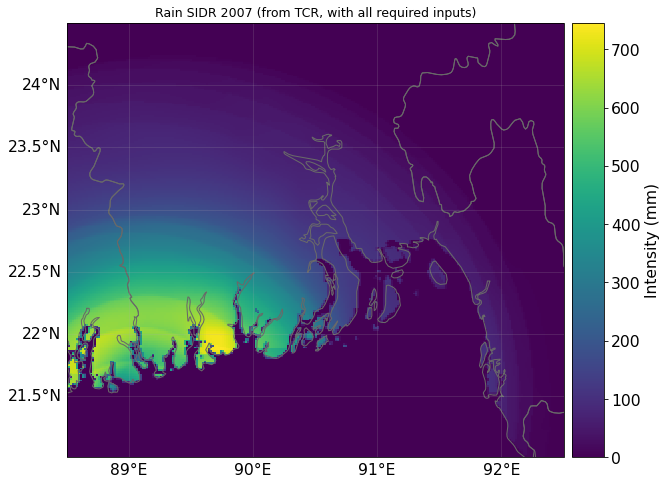

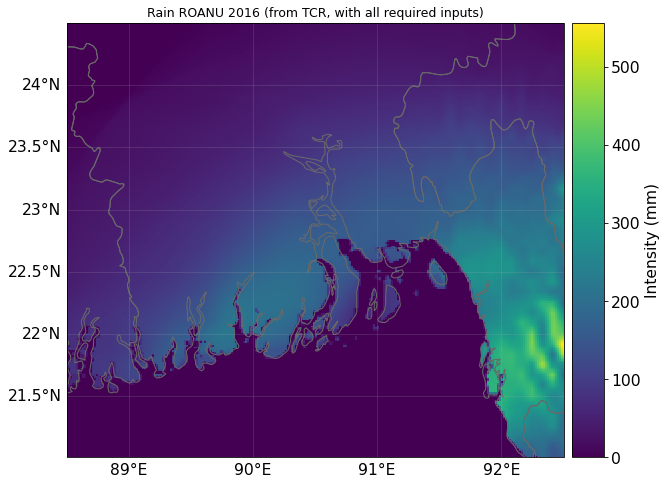

In [6]:
from climada.util.constants import DEMO_DIR

tracks = TCTracks.from_hdf5(DEMO_DIR / "tcrain_examples.nc")
tracks.equal_timestep(0.5)

tr_bang = TCRain.from_tracks(tracks, centroids=cent_bang, model="TCR")
ax = tr_bang.plot_intensity(1)
ax.set_title('Rain SIDR 2007 (from TCR, with all required inputs)')
ax = tr_bang.plot_intensity(2)
ax.set_title('Rain ROANU 2016 (from TCR, with all required inputs)');